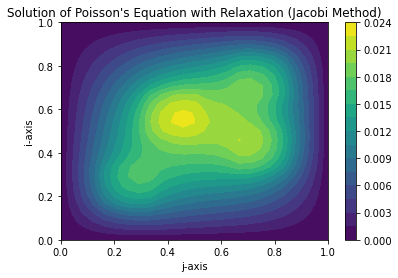

In [1]:

# test activated or not
def is_acti(acti_lst,cord):
    flag = 0
    for block in acti_lst:
        ac_y_cor = (block-1)//4
        ac_x_cor = (block-1)%4
        x_l = 1/6*(1+ac_x_cor)
        x_h = 1/6*(2+ac_x_cor)
        y_l = 1/6*(1+ac_y_cor)
        y_h = 1/6*(2+ac_y_cor)
        if cord[0] >= x_l and cord[0] <= x_h and cord[1] >= y_l and cord[1] <= y_h:
            flag = 1
    return flag
# Define the grid size N

import numpy as np
import matplotlib.pyplot as plt

def relax(u, f,  nu, dx,omega,method):
    assert method == 'GS' or method == 'Jacobi'
    N = u.shape[0]
    u_new = np.copy(u)
    for _ in range(nu):
        for i in range(1, N - 1):
            for j in range(1, N - 1):
                #u_new[i, j] = 0.25 * (u[i - 1, j] + u[i + 1, j] + u[i, j - 1] + u[i, j + 1] - h * h * f[i, j])
                if method == 'Jacobi':
                    u_new[i, j] = (1 - omega) * u[i, j] + (omega / 4) * (
                    u[i + 1, j] + u[i - 1, j] + u[i, j + 1] + u[i, j - 1] + f[i,j]*(dx**2)) 
                if method == 'GS':
                    u_new[i, j] = (1 - omega) * u[i, j] + (omega / 4) * (
                    u[i + 1, j] + u_new[i - 1, j] + u[i, j + 1] + u_new[i, j - 1] + f[i,j]*(dx**2)) 
        u, u_new = u_new, u
    return u
        
        
def restrict(r):
    
    N = r.shape[0]
    Nc = N  // 2
    rc = np.zeros((Nc, Nc))
    for i in range(1, Nc - 1):
        for j in range(1, Nc - 1):
            #rc[i, j] = 0.25 * (r[2 * i, 2 * j] + r[2 * i + 1, 2 * j] + r[2 * i, 2 * j + 1] + r[2 * i + 1, 2 * j + 1])
            rc[i,j] = r[2*i,2*j]
    
    return rc

def calc_res(f,u,dx):
    N = f.shape[0]
    u_res = np.zeros((N+1, N+1))
    for i in range(1, N - 1):
        for j in range(1, N - 1):
            #u_res[i,j] = f[i,j] + (4*u[i, j] -  (u[i - 1, j] + u[i + 1, j] + u[i, j - 1] + u[i, j + 1] ) )/(h**2)

            u_res[i,j] = (-u[i, j] + (1 / 4) * (
            u[i + 1, j] + u[i - 1, j] + u[i, j + 1] + u[i, j - 1] + f[i,j]*(dx**2)) ) / (0.25*dx**2)
    return u_res

    
def interpolate(e):
    Nc = e.shape[0]
    N = 2 * Nc 
    ef = np.zeros((N+1, N+1))
    for i in range(1, N ):
        for j in range(1, N ):
            ef[i, j] = e[i // 2, j // 2]
    return ef

def two_grid_cycle( u, f ,A , h, nu1, nu2, nuc, iteration,N,omega,method):
    u_temp = np.copy(u)
    for iteri in range(iteration):
        # Relaxation with initial guess
        u1_3 = relax(u_temp, f,  nu1, h,omega,method)
         

        # Compute residual and restrict
        #r = f - (A.reshape(((N+1)**2,(N+1)**2)) .dot( u1_3.reshape((N+1)**2))).reshape((N+1,N+1))
        r = calc_res(f,u1_3,h)
        rc = restrict(r)

        #print('r',np.linalg.norm((r).reshape((r.shape[0])**2), ord=2))
        #print(rc)
        # Coarse grid correction
        #eh = np.linalg.solve(A_res.reshape(((N//2)**2,(N//2)**2)), rc.reshape((N//2)**2)).reshape((N//2,N//2))
        eh = relax(np.zeros(((N ) // 2,(N ) // 2)), rc,  nuc, 2*h,omega,method)
        # Prolongate and correct
        e = interpolate(eh)
        u2_3 = u1_3 + e  ##############

        # Relaxation with corrected guess
        u_temp = relax(u2_3, f,  nu2, h,omega,method)
       
        
    return u_temp

# Set up your grid, boundary conditions, and f (right-hand side)
method = 'GS'
omega = 1
N = 25 - 1
dx = 1.0 / N
u = np.zeros((N+1, N+1))
f = np.zeros((N+1, N+1))
act_lst = [1,7,14,16]
for i in range(0,N+1):
    for j in range(0,N+1):
        if is_acti(act_lst,(i*dx,j*dx)):
        #if i<2:
            f[i,j] = 1

A = np.zeros((N + 1, N + 1, N + 1, N + 1))
for i in range(0, N+1):
    for j in range(0, N+1):
        A[i,j,i,j] = 1
        if i in range(1, N) and j in range(1, N):
            A[i,j,i+1,j] = -0.25
            A[i,j,i-1,j] = -0.25
            A[i,j,i,j+1] = -0.25
            A[i,j,i,j-1] = -0.25
            


# Number of iterations for relaxation
nu1 = 2
nu2 = 2
nuc = 100
iteration = 50

# Perform a two-grid cycle
u = two_grid_cycle(u, f, A, dx,nu1, nu2, nuc, iteration,N,omega,method)




x = np.linspace(0, 1, N + 1)  # x-coordinates
y = np.linspace(0, 1, N + 1)  # y-coordinates
# Plot the solution
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, u, levels=20, cmap='viridis')
plt.colorbar()
plt.title("Solution of Poisson's Equation with Relaxation (Jacobi Method)")
plt.xlabel("j-axis")
plt.ylabel("i-axis")
plt.show()



In [2]:
# Initialize arrays to store gradient values on each boundary
gradient_top = np.zeros(N + 1)
gradient_bottom = np.zeros(N + 1)
gradient_left = np.zeros(N + 1)
gradient_right = np.zeros(N + 1)


for i in range(N + 1):
    gradient_right[i] = -(3*u[i, -1] - 4 * u[i, -2] +  u[i, -3]) / (2 * dx)
    


for j in range(N + 1):
    gradient_top[j] =(3*u[-3, j] - 4 * u[-2, j] +  u[-1, j]) / (2 * dx)



for i in range(N + 1):
    gradient_left[i] = -(3 * u[i, 0] - 4 * u[i, 1] + u[i, 2]) / (2 * dx)


for j in range(N + 1):
    gradient_bottom[j] = -(3 * u[0, j] - 4 * u[1, j] + u[2, j]) / (2 * dx)




# Print the gradient values

print("\nGradient on the left boundary (j = 0):")
print(gradient_left)

print("\nGradient on the right boundary (j = L):")
print(gradient_right)


print("\nGradient on the bottom boundary (i = 0):")
print(gradient_bottom)

print("Gradient on the top boundary (i = L):")
print(gradient_top)



Gradient on the left boundary (j = 0):
[-0.          0.01224965  0.02438907  0.03606816  0.04657431  0.05517941
  0.06117528  0.06431381  0.06486783  0.06356262  0.06112946  0.05826522
  0.0552769   0.05217749  0.04885559  0.04519463  0.04113172  0.0366709
  0.03186864  0.02680805  0.02157378  0.01623575  0.01084317  0.00542594
 -0.        ]

Gradient on the right boundary (j = L):
[-0.          0.00715823  0.01449214  0.02217081  0.03033841  0.03906846
  0.04827153  0.05755734  0.06616762  0.07335026  0.07840662  0.08113256
  0.08186494  0.08136966  0.08030169  0.07901807  0.07713523  0.07396845
  0.06871538  0.06099277  0.05094506  0.03919576  0.02640692  0.01323927
 -0.        ]

Gradient on the bottom boundary (i = 0):
[-0.          0.01224002  0.02435055  0.03596254  0.04634572  0.05475784
  0.06048393  0.0632823   0.0634521   0.0617709   0.05904978  0.05608547
  0.05328505  0.05073095  0.04831845  0.04585363  0.04311481  0.03989617
  0.0360414   0.03146766  0.02617468  0.0202373

In [3]:
# Initialize arrays to store gradient values on each boundary
gradient_top = np.zeros(N + 1)
gradient_bottom = np.zeros(N + 1)
gradient_left = np.zeros(N + 1)
gradient_right = np.zeros(N + 1)


for i in range(N + 1):
    gradient_right[i] = -(3*u[i, -1] - 4 * u[i, -2] +  u[i, -3]) / (2 * dx)
    


for j in range(N + 1):
    gradient_top[j] =(3*u[-3, j] - 4 * u[-2, j] +  u[-1, j]) / (2 * dx)



for i in range(N + 1):
    gradient_left[i] = -(3 * u[i, 0] - 4 * u[i, 1] + u[i, 2]) / (2 * dx)


for j in range(N + 1):
    gradient_bottom[j] = -(3 * u[0, j] - 4 * u[1, j] + u[2, j]) / (2 * dx)




# Print the gradient values

print("\nGradient on the left boundary (j = 0):")
print(gradient_left)

print("\nGradient on the right boundary (j = L):")
print(gradient_right)


print("\nGradient on the bottom boundary (i = 0):")
print(gradient_bottom)

print("Gradient on the top boundary (i = L):")
print(gradient_top)



Gradient on the left boundary (j = 0):
[-0.          0.01224965  0.02438907  0.03606816  0.04657431  0.05517941
  0.06117528  0.06431381  0.06486783  0.06356262  0.06112946  0.05826522
  0.0552769   0.05217749  0.04885559  0.04519463  0.04113172  0.0366709
  0.03186864  0.02680805  0.02157378  0.01623575  0.01084317  0.00542594
 -0.        ]

Gradient on the right boundary (j = L):
[-0.          0.00715823  0.01449214  0.02217081  0.03033841  0.03906846
  0.04827153  0.05755734  0.06616762  0.07335026  0.07840662  0.08113256
  0.08186494  0.08136966  0.08030169  0.07901807  0.07713523  0.07396845
  0.06871538  0.06099277  0.05094506  0.03919576  0.02640692  0.01323927
 -0.        ]

Gradient on the bottom boundary (i = 0):
[-0.          0.01224002  0.02435055  0.03596254  0.04634572  0.05475784
  0.06048393  0.0632823   0.0634521   0.0617709   0.05904978  0.05608547
  0.05328505  0.05073095  0.04831845  0.04585363  0.04311481  0.03989617
  0.0360414   0.03146766  0.02617468  0.0202373